In [1]:
import numpy as np
import torch
import torch.nn as nn
from tqdm import tqdm

In [2]:
# make debug.txt in dir: debug/
import os

def write_debug(header:str, debug_npy:np.array):
    # convert numpy array to string
    debug_str = ''
    for i in range(debug_npy.shape[0]):
        for j in range(debug_npy.shape[1]):
            debug_str += str(debug_npy[i][j])[0:5] + ' '
        debug_str += '\n'
        
    # write debug_str to debug.txt
    with open('debug/debug.txt', 'a') as f:
        f.write(header+': \t'+debug_str + '\n')

In [3]:
# clear debug.txt
with open('debug/debug.txt', 'w') as f:
    f.write('')

class Script_DiaNet(nn.Module):

    def __init__(self, inp_num, out_num, device='cpu'):
        super(Script_DiaNet, self).__init__()
        self.log = False
        
        self.red_depths = list(range(2, 1000))
        self.red_fulls = [sum(range(1, n+2)) for n in self.red_depths]
        self.red_heads = [(x * 2) + 1 for x in self.red_depths]

        self.red_full = -1
        self.red_dep = -1
        self.red_triangle = []
        self.jump_weights = nn.ParameterList()
        self.layers, self.masks = self.gen_layers(inp_num, out_num)
        # each mask to device
        for i in range(len(self.masks)):
            self.masks[i] = self.masks[i].to(device)
        # each layers multiply mask
        self.x_hidden = []
        for i in range(len(self.layers)):
            self.layers[i].weight.data = self.layers[i].weight.data * self.masks[i]
            self.x_hidden.append(-1) # init x_hidden
        
    
    def select_insert(self, n, sel_len) -> list:
        assert (((n - 1) // 2) % 2) == (sel_len % 2), "Invalid selection length"
        numbers = range(n)
        odd_numbers = [num for num in numbers if num % 2 == 1]
        center_index = len(odd_numbers) // 2
        selected_numbers = odd_numbers[center_index - sel_len // 2: center_index + sel_len // 2 + (sel_len % 2)]
        return selected_numbers if sel_len != 1 else selected_numbers
        
    def gen_layers(self, inp_num, out_num):
        # create Red triangle(input triangle)
        masks_list = []
        self.bn_list = [] # batch norm list

        # select input triangle by input num
        red_dep, red_head = -1, -1
        for i in range(len(self.red_fulls)-1):
            if inp_num > self.red_fulls[i] and inp_num <= self.red_fulls[i+1]:
                red_full = self.red_fulls[i+1]
                red_dep = self.red_depths[i+1]
                red_head = self.red_heads[i+1]
                if self.log: print("red_dep:", red_dep, "red_head:", red_head)
                break
        assert (red_dep>0)and(red_head>0), "red_dep {} or head {} is not valid".format(red_dep, red_head)
        self.red_dep = red_dep
        self.red_full = red_full
        for i in range(red_dep, 0, -1):
            if i == red_dep:
                self.red_triangle.append(i*2+1)
            else:
                self.red_triangle.append(i)

        
        # create blue triangle(output triangle)
        nn_output = out_num + (out_num-1)
        blue_dep = int(nn_output/2-0.5)
        if self.log:print("blue_dep:", blue_dep)

        total_dep = red_dep + blue_dep
        if self.log:print("total_dep:", total_dep)

        # expand times
        expand_times = total_dep - red_dep
        if self.log:print("expand_times:", expand_times)

        # create expand time nn layer
        expand_list = []
        expand_list.append(nn.Linear(red_head, red_head-2, bias=False)) # first layer
        self.bn_list.append(nn.BatchNorm1d(red_head-2))
        self.jump_weights.append(nn.Parameter(torch.randn(1, red_head-2))) # Not in use

        masks_list.append(self.fst_mask(red_head, red_head-2))
        nn_in = red_head-2
        for i in range(expand_times):
            expand_list.append(nn.Linear(nn_in, nn_in+2, bias=False))
            self.bn_list.append(nn.BatchNorm1d(nn_in+2))
            masks_list.append(self.exp_mask_v2(nn_in, nn_in+2))
            self.jump_weights.append(nn.Parameter(torch.randn(1, nn_in-2)))
            nn_in += 2
        if self.log:print("expand_list:", expand_list)

        # shrink times
        shrink_times = total_dep - blue_dep - 1
        # if self.log:print("shrink_times:", shrink_times)
        shrink_list = []
        for i in range(shrink_times):
            shrink_list.append(nn.Linear(nn_in, nn_in-2, bias=False))
            self.bn_list.append(nn.BatchNorm1d(nn_in-2))
            masks_list.append(self.shr_mask_v2(nn_in, nn_in-2))
            self.jump_weights.append(nn.Parameter(torch.randn(1, nn_in-2)))
            nn_in -= 2
        if self.log:print("shrink_list:", shrink_list)

        # combine expand and shrink list
        layer_list = expand_list + shrink_list
        layers = nn.Sequential(*layer_list)
        assert len(masks_list) == len(layer_list), "masks_list {} and layer_list {} is not same".format(len(masks_list), len(layer_list))

        return layers, masks_list
    
    def fst_mask(self, in_dim, out_dim):
        assert in_dim-out_dim == 2, "fst_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
        mask = torch.zeros((out_dim, in_dim))
        for i in range(out_dim):
            if i%2 == 0:
                start_idx = i
                end_idx = i+2 + 1
                mask[i, start_idx:end_idx] = 1
        return mask
    
    def exp_mask(self, in_dim, out_dim):
        assert out_dim-in_dim == 2, "exp_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
        mask = torch.zeros((out_dim, in_dim))
        for i in range(out_dim):
            if i%2 == 0:
                a = max(0, i-4)
                b = min(max(0, i-2), in_dim-1)
                c = min(max(0, i-1), in_dim-1)
                d = min(max(0, i), in_dim-1)
                e = min(max(0, i+2), in_dim-1)
                idx_lis = [a,b,c,d,e]
                mask[i, idx_lis] = 1
        return mask
    
    def shr_mask(self, in_dim, out_dim):
        assert in_dim-out_dim == 2, "shr_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
        mask = torch.zeros((out_dim, in_dim))
        for i in range(out_dim):
            if i%2 == 0:
                a = max(0, i-2)
                b = min(max(0, i), in_dim-1)
                c = min(max(0, i+1), in_dim-1)
                d = min(max(0, i+2), in_dim-1)
                e = min(max(0, i+4), in_dim-1)
                idx_lis = [a,b,c,d,e]
                mask[i, idx_lis] = 1
        return mask

    def exp_mask_v2(self, in_dim, out_dim):
        assert out_dim-in_dim == 2, "exp_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
        mask = torch.zeros((out_dim, in_dim))
        for i in range(out_dim):
            if i%2 == 0:
                a = max(0, i-6)
                b = min(max(0, i-4), in_dim-1)
                c = min(max(0, i-2), in_dim-1)
                d = min(max(0, i-1), in_dim-1)
                e = min(max(0, i), in_dim-1)
                f = min(max(0, i+2), in_dim-1)
                g = min(max(0, i+4), in_dim-1)
                idx_lis = [a,b,c,d,e,f,g]
                mask[i, idx_lis] = 1
        return mask

    def shr_mask_v2(self, in_dim, out_dim):
        assert in_dim-out_dim == 2, "shr_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
        mask = torch.zeros((out_dim, in_dim))
        for i in range(out_dim):
            if i%2 == 0:
                a_ = max(0, i-4)
                a = min(max(0, i-2), in_dim-1)
                b = min(max(0, i), in_dim-1)
                c = min(max(0, i+1), in_dim-1)
                d = min(max(0, i+2), in_dim-1)
                e = min(max(0, i+4), in_dim-1)
                e_ = min(max(0, i+6), in_dim-1)
                idx_lis = [a_,a,b,c,d,e,e_]
                mask[i, idx_lis] = 1
        return mask
                

    def forward(self, x):
        container = torch.zeros((x.shape[0], self.red_full)) # (b, 28)
        container[:, 0:x.shape[1]] = x
        # split x for red triangle, froexample, 25-> 13,5,4,3,2,1
        x_seg = []
        slice_idx = 0
        for i in range(self.red_dep, 0, -1):
            if i == self.red_dep:
                x_seg.append(container[:, 0:i*2+1]) # 13
                slice_idx += i*2+1
            else:
                x_seg.append(container[:, slice_idx:slice_idx+i]) # 13:18, 18:22, 22:25, 25:27, 27:28
                slice_idx += i
        if self.log: 
            for seg in x_seg: print(seg)
        if self.log: print('*'*30)

        for i, layer in enumerate(self.layers):
            # red triangle stage
            if i == 0:
                layer.weight.data = torch.clamp(layer.weight.data, min=-1, max=1)
                layer.weight.data *= self.masks[i]
                x = layer(x_seg[i])
                x = torch.tanh(x)
                # x = self.bn_list[i](x)
                if self.log: write_debug('layer{}, x'.format(i), x.detach().numpy())
                self.x_hidden[i] = x
            
            elif i == 1:
                if self.log: write_debug('layer{}, x'.format(i), x.detach().numpy())
                assert torch.sum(x[:, 1::2]) == 0, "x[:, 1::2] is not 0"
                layer.weight.data = torch.clamp(layer.weight.data, min=-1, max=1)
                layer.weight.data *= self.masks[i]
                x_cpy = x.clone()
                this_len, red_tri_layer_num = x_cpy.shape[1], self.red_triangle[i]
                sel_insert = self.select_insert(this_len, red_tri_layer_num)
                # if self.log: print("sel_insert:", sel_insert)
                assert x_cpy[:, sel_insert].shape == x_seg[i].shape, "x_cpy[:, sel_insert] shape {} and x_seg[i] shape {} is not same".format(x_cpy[:, sel_insert].shape, x_seg[i].shape)
                if self.log: write_debug('layer{}, seg'.format(i), x_seg[i].detach().numpy())
                x_cpy[:, sel_insert] += x_seg[i]
                x = x_cpy
                if self.log: write_debug('layer{}, x insrt'.format(i), x.detach().numpy())
                x = layer(x)
                x = torch.tanh(x)
                # x = self.bn_list[i](x)
                self.x_hidden[i] = x

            elif i > 1 and i < self.red_dep:
                if self.log: write_debug('layer{}, x'.format(i), x.detach().numpy())
                assert torch.sum(x[:, 1::2]) == 0, "x[:, 1::2] is not 0"
                layer.weight.data = torch.clamp(layer.weight.data, min=-1, max=1)
                layer.weight.data *= self.masks[i]
                x_cpy = x.clone()
                this_len = x_cpy.shape[1]
                red_tri_layer_num = self.red_triangle[i]
                sel_insert = self.select_insert(this_len, red_tri_layer_num)
                # if self.log: print("sel_insert:", sel_insert)
                assert x_cpy[:, sel_insert].shape == x_seg[i].shape, "x_cpy[:, sel_insert] shape {} and x_seg[i] shape {} is not same".format(x_cpy[:, sel_insert].shape, x_seg[i].shape)
                if self.log: write_debug('layer{}, seg'.format(i), x_seg[i].detach().numpy())
                # insert input segment to x_cpy
                x_cpy[:, sel_insert] += x_seg[i]
                x = x_cpy
                if self.log: write_debug('layer{}, x insrt'.format(i), x.detach().numpy())
                x = layer(x)
                if self.log: write_debug('layer{}, x fc'.format(i), x.detach().numpy())
                # jump connection, add prevprev layer output to this layer output
                jump = self.x_hidden[i-2]
                if self.log: write_debug('layer{}, jump'.format(i), jump.detach().numpy())
                assert torch.sum(jump[:, 1::2]) == 0, "jump[:, 1::2] is not 0"
                assert (jump.shape[1] == x.shape[1]+4) or (jump.shape[1] == x.shape[1]-4) or (jump.shape[1] == x.shape[1]), "jump.shape[1] {} and x.shape[1] {} is not valid".format(jump.shape[1], x.shape[1])
                x_cpy = x.clone()
                # compare x_cpy and jump
                # jump_w = self.jump_weights[i]
                # jump_w = torch.clamp(jump_w, min=-1, max=1)
                if x_cpy.shape[1] > jump.shape[1]:
                    x_cpy[:, 2:-2] += jump #* jump_w
                elif x_cpy.shape[1] == jump.shape[1]:
                    x_cpy += jump #* jump_w
                else:
                    x_cpy += jump[:, 2:-2] #* jump_w
                x = x_cpy
                if self.log: write_debug('layer{}, jump_w'.format(i), self.jump_weights[i].detach().numpy())
                if self.log: write_debug('layer{}, x jump'.format(i), x.detach().numpy())
                x = torch.tanh(x)
                # x = self.bn_list[i](x)
                self.x_hidden[i] = x

            elif i >= self.red_dep:
                if self.log: write_debug('layer{}, x'.format(i), x.detach().numpy())
                assert torch.sum(x[:, 1::2]) == 0, "x[:, 0::2] is not 0"
                layer.weight.data = torch.clamp(layer.weight.data, min=-1, max=1)
                layer.weight.data *= self.masks[i]
                x = layer(x)
                if self.log: write_debug('layer{}, x fc'.format(i), x.detach().numpy())
                jump = self.x_hidden[i-2]
                if self.log: write_debug('layer{}, jump'.format(i), jump.detach().numpy())
                assert torch.sum(jump[:, 1::2]) == 0, "jump[:, 1::2] is not 0"
                assert (jump.shape[1] == x.shape[1]+4) or (jump.shape[1] == x.shape[1]-4) or (jump.shape[1] == x.shape[1]), "jump.shape[1] {} and x.shape[1] {} is not valid".format(jump.shape[1], x.shape[1])
                x_cpy = x.clone()
                # compare x_cpy and jump
                # jump_w = self.jump_weights[i]
                # jump_w = torch.clamp(jump_w, min=-1, max=1)
                if x_cpy.shape[1] > jump.shape[1]:
                    x_cpy[:, 2:-2] += jump #* jump_w
                elif x_cpy.shape[1] == jump.shape[1]:
                    x_cpy += jump #* jump_w
                else:
                    x_cpy += jump[:, 2:-2] #* jump_w
                x = x_cpy
                if self.log: write_debug('layer{}, jump_w'.format(i), self.jump_weights[i].detach().numpy())
                if self.log: write_debug('layer{}, x jump'.format(i), x.detach().numpy())
                x = torch.tanh(x)
                # x = self.bn_list[i](x)
                self.x_hidden[i] = x
            
        # select all the even index of x
        x = x[:, 0::2]

        return x
            
            

model = Script_DiaNet(25, 10)

x = torch.randn(1, 25)
res = model(x)
tar = torch.randn(1, 10)
mseloss = torch.nn.MSELoss()
loss = mseloss(res, tar)
print(loss)
loss.backward()



tensor(1.7046, grad_fn=<MseLossBackward0>)


In [23]:
mm = Script_DiaNet(100, 10)
# print(mm)
count = 0
for layer in mm.layers:
    for i in range(layer.weight.data.shape[0]):
        for j in range(layer.weight.data.shape[1]):
            if layer.weight.data[i][j] != 0.0:
                count += 1
                
print(count)

2277


In [15]:
def exp_mask(in_dim, out_dim):
    assert out_dim-in_dim == 2, "exp_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
    mask = torch.zeros((out_dim, in_dim))
    for i in range(out_dim):
        if i%2 == 0:
            a = max(0, i-6)
            b = min(max(0, i-4), in_dim-1)
            c = min(max(0, i-2), in_dim-1)
            d = min(max(0, i-1), in_dim-1)
            e = min(max(0, i), in_dim-1)
            f = min(max(0, i+2), in_dim-1)
            g = min(max(0, i+4), in_dim-1)
            idx_lis = [a,b,c,d,e,f,g]
            mask[i, idx_lis] = 1
    return mask

# exp_mask(15, 17)

def shr_mask(in_dim, out_dim):
    assert in_dim-out_dim == 2, "shr_mask: in_dim {} and out_dim {} is not valid".format(in_dim, out_dim)
    mask = torch.zeros((out_dim, in_dim))
    for i in range(out_dim):
        if i%2 == 0:
            a_ = max(0, i-4)
            a = min(max(0, i-2), in_dim-1)
            b = min(max(0, i), in_dim-1)
            c = min(max(0, i+1), in_dim-1)
            d = min(max(0, i+2), in_dim-1)
            e = min(max(0, i+4), in_dim-1)
            e_ = min(max(0, i+6), in_dim-1)
            idx_lis = [a_,a,b,c,d,e,e_]
            mask[i, idx_lis] = 1
    return mask

shr_mask(17, 15)

tensor([[1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1.,

In [7]:
lis = [79, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]
# sum th lis
sum(lis)

820

In [25]:
import matplotlib.pyplot as plt
import networkx as nx
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

def draw_dianet(model, nodesize=50, figsize=(15, 10)):

    layers = [layer for layer in model.layers if isinstance(layer, nn.Linear)]
    G = nx.DiGraph()

    # 计算每层的节点数并找到最大值
    max_nodes = max(max(layer.weight.shape[0], layer.weight.shape[1]) for layer in layers)

    # 计算每个节点的位置
    pos = {}
    for i, layer in enumerate(layers):
        num_nodes_input = layer.weight.shape[1]
        num_nodes_output = layer.weight.shape[0]
        
        for j in range(num_nodes_input):
            x = i * 2 # 水平间距
            y = (max_nodes - num_nodes_input) / 2 + j # 垂直居中
            pos[f'{i}_{j}'] = (x, y)

        for j in range(num_nodes_output):
            x = (i + 1) * 2 # 水平间距
            y = (max_nodes - num_nodes_output) / 2 + j # 垂直居中
            pos[f'{i+1}_{j}'] = (x, y)

    for i, layer in tqdm(enumerate(layers)):
        weight = layer.weight.detach().numpy()

        for j in range(weight.shape[1]): # 输入特征
            for k in range(weight.shape[0]): # 输出特征
                G.add_edge(f'{i}_{j}', f'{i+1}_{k}', weight=weight[k, j])
                # pos[f'{i}_{j}'] = (i, j)
                # pos[f'{i+1}_{k}'] = (i+1, k)

    edges = G.edges(data=True)
    # colors = ['lightblue' if edge[2]['weight'] != 0.0 else 'none' for edge in edges] # 单色
    colors0 = [edge[2]['weight'] for edge in edges]
    colors = []
    for color_val in colors0:
        if color_val == 0.0:
            colors.append('none')
        elif color_val > 0.0:
            colors.append('lightcoral') # lightcoral
        else:
            colors.append('lightcoral')

    fig, ax = plt.subplots(figsize=figsize) # 设置图像大小
    nx.draw(G, pos, edge_color=colors, node_size=nodesize, 
            with_labels=False, ax=ax) #edge_cmap=plt.cm.PiYG
    plt.title("Visualization of Script_DiaNet Model") # 设置标题
    plt.show()


red_dep: 10 red_head: 21
blue_dep: 9
total_dep: 19
expand_times: 9
expand_list: [Linear(in_features=21, out_features=19, bias=False), Linear(in_features=19, out_features=21, bias=False), Linear(in_features=21, out_features=23, bias=False), Linear(in_features=23, out_features=25, bias=False), Linear(in_features=25, out_features=27, bias=False), Linear(in_features=27, out_features=29, bias=False), Linear(in_features=29, out_features=31, bias=False), Linear(in_features=31, out_features=33, bias=False), Linear(in_features=33, out_features=35, bias=False), Linear(in_features=35, out_features=37, bias=False)]
shrink_list: [Linear(in_features=37, out_features=35, bias=False), Linear(in_features=35, out_features=33, bias=False), Linear(in_features=33, out_features=31, bias=False), Linear(in_features=31, out_features=29, bias=False), Linear(in_features=29, out_features=27, bias=False), Linear(in_features=27, out_features=25, bias=False), Linear(in_features=25, out_features=23, bias=False), Line

19it [00:00, 1357.03it/s]


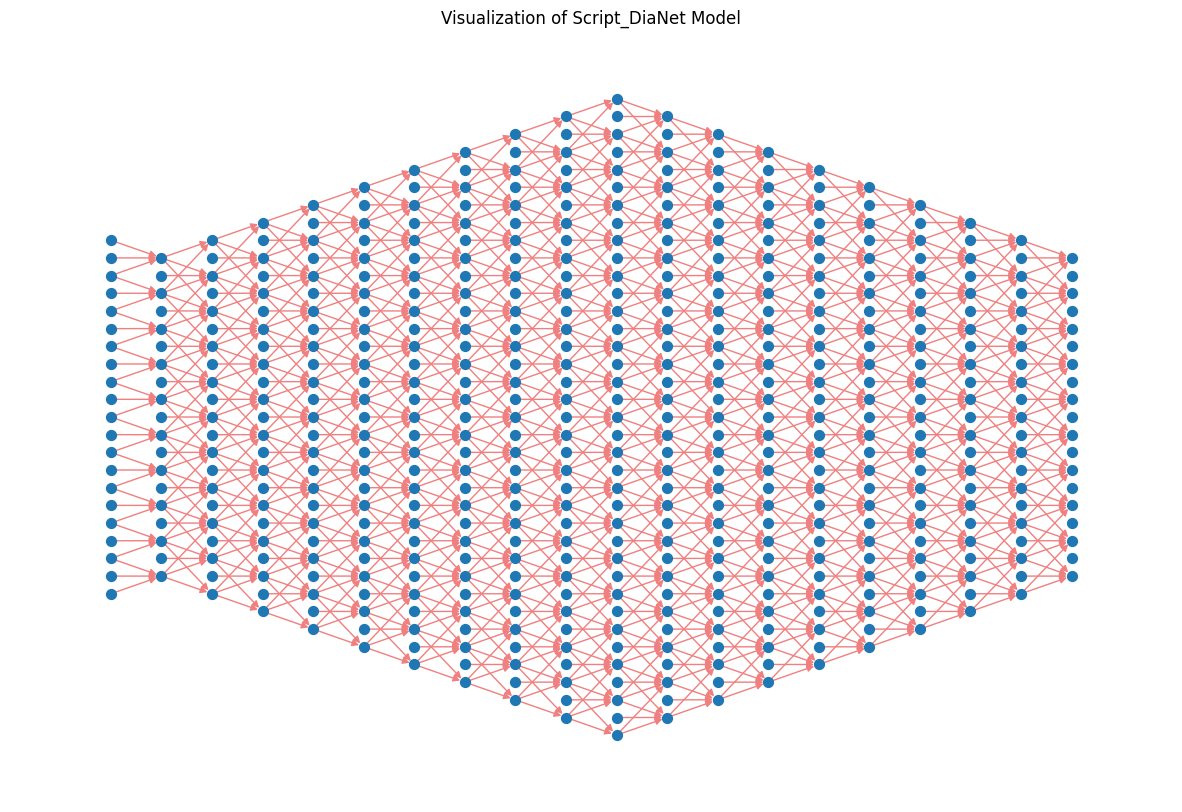

In [26]:
model = Script_DiaNet(64, 10)
draw_dianet(model)

In [ ]:
model = Script_DiaNet(784, 10)
draw_dianet(model, 10, (150, 100))

red_dep: 6 red_head: 13
blue_dep: 0
total_dep: 6
expand_times: 0
expand_list: [Linear(in_features=13, out_features=11, bias=False)]
shrink_list: [Linear(in_features=11, out_features=9, bias=False), Linear(in_features=9, out_features=7, bias=False), Linear(in_features=7, out_features=5, bias=False), Linear(in_features=5, out_features=3, bias=False), Linear(in_features=3, out_features=1, bias=False)]


6it [00:00, ?it/s]


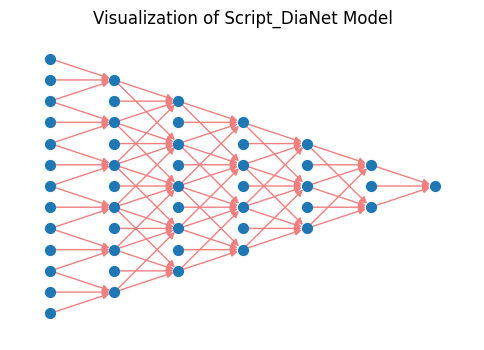

In [28]:
model = Script_DiaNet(25, 1)
draw_dianet(model, 50, (6,4))

### test some funcs

In [33]:
def GEN(inp_num, out_num):

    logg = True
    # create Red triangle(input triangle)
    red_fulls =  [6,10,15,21,28,36,45,55,66,78,91,105,120,136]
    red_depths = [2,3, 4, 5, 6, 7, 8, 9, 10,11,12,13, 14, 15]
    red_heads =  [ x*2+1 for x in red_depths]

    # select input triangle by input num
    red_dep, red_head = -1, -1
    for i in range(len(red_fulls)-1):
        if inp_num > red_fulls[i] and inp_num <= red_fulls[i+1]:
            red_dep = red_depths[i+1]
            red_head = red_heads[i+1]
            if logg: print("red_dep:", red_dep, "red_head:", red_head)
            break
    assert (red_dep>0)and(red_head>0), "red_dep {} or head {} is not valid".format(red_dep, red_head)
    
    # create blue triangle(output triangle)
    nn_output = out_num + (out_num-1)
    blue_dep = int(nn_output/2-0.5)
    if logg:print("blue_dep:", blue_dep)

    total_dep = red_dep + blue_dep
    if logg:print("total_dep:", total_dep)

    # expand times
    expand_times = total_dep - red_dep
    if logg:print("expand_times:", expand_times)

    # create expand time nn layer
    expand_list = []
    expand_list.append((red_head, red_head-2)) # first layer
    nn_in = red_head-2
    for i in range(expand_times):
        expand_list.append((nn_in, nn_in+2))
        # if logg:print("layer_list:", (nn_in, nn_in+2))
        nn_in += 2
    if logg:print("layer_list:", expand_list)

    # shrink times
    shrink_times = total_dep - blue_dep - 1
    if logg:print("shrink_times:", shrink_times)
    shrink_list = []
    nn_in = expand_list[-1][1]
    if logg:print("shrink init nn_in:", nn_in)
    for i in range(shrink_times):
        shrink_list.append((nn_in, nn_in-2))
        nn_in -= 2
    if logg:print("layer_list:", shrink_list)


GEN(64, 10)

red_dep: 10 red_head: 21
blue_dep: 9
total_dep: 19
expand_times: 9
layer_list: [(21, 19), (19, 21), (21, 23), (23, 25), (25, 27), (27, 29), (29, 31), (31, 33), (33, 35), (35, 37)]
shrink_times: 9
shrink init nn_in: 37
layer_list: [(37, 35), (35, 33), (33, 31), (31, 29), (29, 27), (27, 25), (25, 23), (23, 21), (21, 19)]


In [65]:
red_depths = list(range(2, 50)) # 从2到19的整数
red_fulls = [sum(range(1, n+2)) for n in red_depths] # 每个数字从1加到n的累加和
red_heads = [(x * 2) + 1 for x in red_depths] # 每个数字乘以2再加1

print("red_fulls:", red_fulls)
print("red_depths:", red_depths)
print("red_heads:", red_heads)

red_fulls: [6, 10, 15, 21, 28, 36, 45, 55, 66, 78, 91, 105, 120, 136, 153, 171, 190, 210, 231, 253, 276, 300, 325, 351, 378, 406, 435, 465, 496, 528, 561, 595, 630, 666, 703, 741, 780, 820, 861, 903, 946, 990, 1035, 1081, 1128, 1176, 1225, 1275]
red_depths: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
red_heads: [5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]
